In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Number of iterations for stability test
num_iterations = 10  # Increase this to get a better estimate of stability

# Row size for stability test
row_size = 1000

# Initialize a dictionary to store precision scores for stability analysis
precision_stability = {
    "BOD": [],
    "Top-K": [],
    "Skyline": [],
    "K-Dominance": [],
    "Pareto Optimality": []
}

def run_single_experiment():
    # Generate random data for location, house, and policy features
    location_data = pd.DataFrame({
        'near_urban': np.random.rand(row_size),      # Higher is better
        'crime_free': np.random.rand(row_size),      # Higher is better
        'view': np.random.rand(row_size)             # Higher is better
    })

    house_data = pd.DataFrame({
        'size': np.random.rand(row_size),            # Higher is better
        'age': np.random.rand(row_size),             # Lower is better
        'style': np.random.rand(row_size)            # Higher is better
    })

    policy_data = pd.DataFrame({
        'policy': np.random.rand(row_size),          # Higher is better
        'tax': np.random.rand(row_size),             # Lower is better
        'growth': np.random.rand(row_size)           # Higher is better
    })

    # Combine the dataframes
    combined_data = pd.concat([location_data, house_data, policy_data], axis=1)

    # Normalize the data
    scaler = MinMaxScaler()
    combined_data_normalized = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

    # Calculate the housing price based on the new criteria (this serves as our target variable)
    housing_prices = (
        1/3 * combined_data_normalized['near_urban'] +
        1.0 * combined_data_normalized['crime_free'] +
        2/3 * combined_data_normalized['view'] +
        1/3 * combined_data_normalized['size'] -
        2/3 * combined_data_normalized['age'] +
        1.0 * combined_data_normalized['style'] +
        1.0 * combined_data_normalized['policy'] -
        1/3 * combined_data_normalized['tax'] +
        2/3 * combined_data_normalized['growth'] +
        np.random.normal(scale=0.1, size=row_size)  # Adding some random noise
    )

    # Assume true labels based on a threshold housing price (dummy example for comparison)
    true_labels = (housing_prices > housing_prices.median()).astype(int)

    ################################### BOD Implementation ###################################
    def bod_algorithm(data):
        # Optimized to use vectorized operations
        selected_columns_1 = data[['crime_free', 'style', 'policy']]
        y_min_1 = selected_columns_1.sum(axis=1).quantile(0.75)
        y_max_1 = selected_columns_1.sum(axis=1).max()

        return_index_list_1 = data[(y_min_1 <= data.sum(axis=1)) & (data.sum(axis=1) <= y_max_1)].index
        filter_1st_dataframe = data.loc[return_index_list_1]

        selected_columns_2 = filter_1st_dataframe[['crime_free', 'style', 'policy', 'view', 'age', 'growth']]
        y_min_2 = selected_columns_2.sum(axis=1).quantile(0.75)
        y_max_2 = selected_columns_2.sum(axis=1).max()

        return_index_list_2 = filter_1st_dataframe[
            (y_min_2 <= filter_1st_dataframe.sum(axis=1)) &
            (filter_1st_dataframe.sum(axis=1) <= y_max_2)
        ].index
        filter_2nd_theFinal_dataframe = filter_1st_dataframe.loc[return_index_list_2]

        selected_columns_3 = filter_2nd_theFinal_dataframe
        y_min_3 = selected_columns_3.sum(axis=1).quantile(0.75)
        y_max_3 = selected_columns_3.sum(axis=1).max()

        return_index_list_3 = filter_2nd_theFinal_dataframe[
            (y_min_3 <= filter_2nd_theFinal_dataframe.sum(axis=1)) &
            (filter_2nd_theFinal_dataframe.sum(axis=1) <= y_max_3)
        ].index

        bod_selection = filter_2nd_theFinal_dataframe.loc[return_index_list_3]
        return bod_selection

    ################################### Unsupervised Top-k Algorithm ###################################
    def unsupervised_top_k_algorithm(data, k=10):
        data['score'] = data.sum(axis=1)
        top_k_selection = data.nlargest(k, 'score')
        return top_k_selection

    ################################### Alternative Skyline Algorithm ###################################
    def alternative_skyline_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        skyline_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            dominated = False
            for j in range(len(skyline_set)):
                if dominates(skyline_set[j], row):
                    dominated = True
                    break
                if dominates(row, skyline_set[j]):
                    skyline_set[j] = row
                    dominated = True
                    break
            if not dominated:
                skyline_set.append(row)

        skyline_df = pd.DataFrame(skyline_set)
        return skyline_df

    ################################### K-Dominance Algorithm ###################################
    def k_dominance_algorithm(data, k=3):
        def k_dominates(row, other_row, k):
            dominance_count = sum(row > other_row)
            return dominance_count >= k

        k_dominant_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            if not any(k_dominates(other_row, row, k) for other_row in data.values):
                k_dominant_set.append(row)

        k_dominant_df = pd.DataFrame(k_dominant_set)
        return k_dominant_df

    ################################### Pareto Optimality Algorithm ###################################
    def pareto_optimal_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        pareto_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            if not any(dominates(other_row, row) for other_row in data.values):
                pareto_set.append(row)

        pareto_df = pd.DataFrame(pareto_set)
        return pareto_df

    ################################### Precision Comparison ###################################
    # BOD Precision
    bod_selection = bod_algorithm(combined_data_normalized)
    bod_precision = precision_score(true_labels[:len(bod_selection)], np.ones(len(bod_selection)), average='binary', zero_division=0)

    # Unsupervised Top-k Precision
    top_k_selection = unsupervised_top_k_algorithm(combined_data_normalized, k=10)
    top_k_precision = precision_score(true_labels[:len(top_k_selection)], np.ones(len(top_k_selection)), average='binary', zero_division=0)

    # Alternative Skyline Precision
    skyline_selection = alternative_skyline_algorithm(combined_data_normalized)
    skyline_precision = precision_score(true_labels[:len(skyline_selection)], np.ones(len(skyline_selection)), average='binary', zero_division=0)

    # K-Dominance Precision
    k_dominance_selection = k_dominance_algorithm(combined_data_normalized, k=3)
    k_dominance_precision = precision_score(true_labels[:len(k_dominance_selection)], np.ones(len(k_dominance_selection)), average='binary', zero_division=0)

    # Pareto Optimality Precision
    pareto_selection = pareto_optimal_algorithm(combined_data_normalized)
    pareto_precision = precision_score(true_labels[:len(pareto_selection)], np.ones(len(pareto_selection)), average='binary', zero_division=0)

    return {
        "BOD": bod_precision,
        "Top-K": top_k_precision,
        "Skyline": skyline_precision,
        "K-Dominance": k_dominance_precision,
        "Pareto Optimality": pareto_precision
    }

# Run the experiments for stability
stability_results = Parallel(n_jobs=-1)(delayed(run_single_experiment)() for _ in range(num_iterations))

# Aggregate results to calculate mean and standard deviation
for algorithm in precision_stability.keys():
    precisions = [result[algorithm] for result in stability_results]
    precision_stability[algorithm] = {
        "mean": np.mean(precisions),
        "std_dev": np.std(precisions)
    }

# Print the stability results
for algorithm, stats in precision_stability.items():
    print(f"{algorithm}: Mean Precision = {stats['mean']:.3f}, Standard Deviation = {stats['std_dev']:.3f}")



BOD: Mean Precision = 0.663, Standard Deviation = 0.340
Top-K: Mean Precision = 0.590, Standard Deviation = 0.158
Skyline: Mean Precision = 0.495, Standard Deviation = 0.006
K-Dominance: Mean Precision = 0.000, Standard Deviation = 0.000
Pareto Optimality: Mean Precision = 0.494, Standard Deviation = 0.009


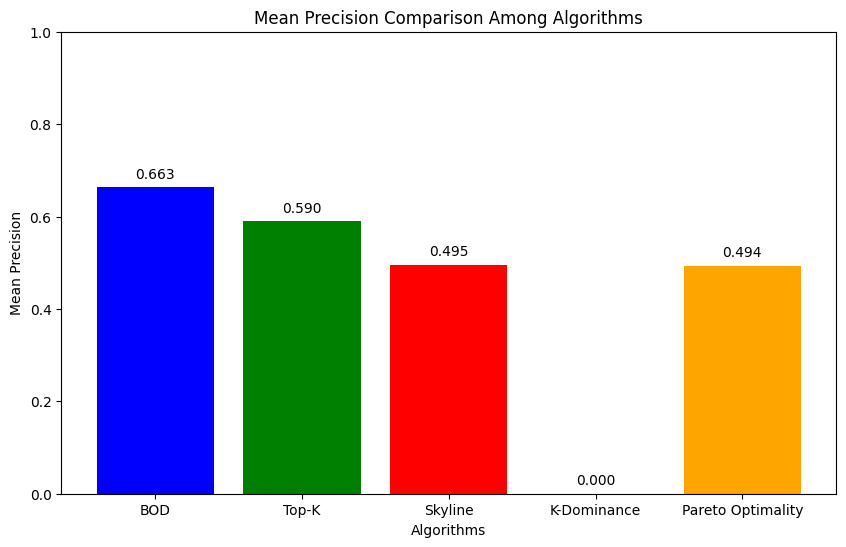

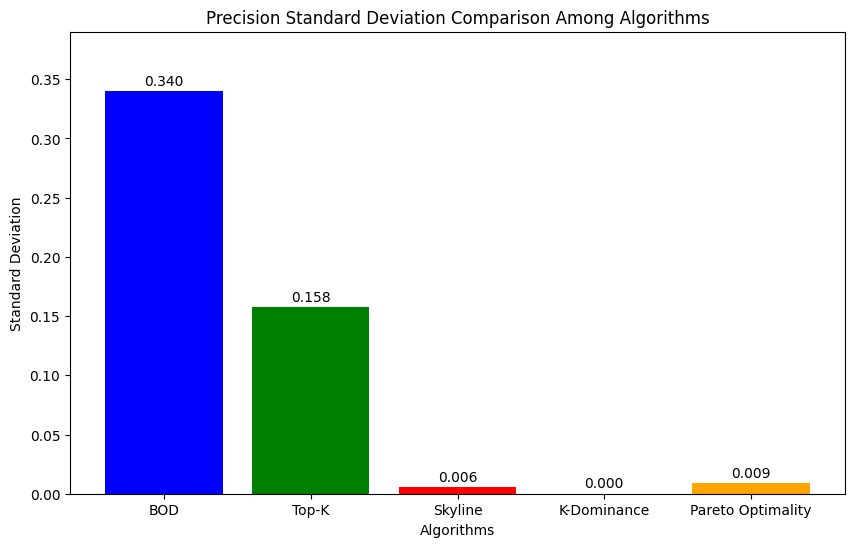

In [ ]:
# Plotting the results

# Extract data for plotting
algorithms = list(precision_stability.keys())
mean_precisions = [precision_stability[alg]["mean"] for alg in algorithms]
std_devs = [precision_stability[alg]["std_dev"] for alg in algorithms]

# Create a bar chart for Mean Precision
plt.figure(figsize=(10, 6))
plt.bar(algorithms, mean_precisions, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Mean Precision Comparison Among Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Mean Precision')
plt.ylim(0, 1)

# Add precision values on top of the bars
for i, v in enumerate(mean_precisions):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.show()

# Create a bar chart for Standard Deviation
plt.figure(figsize=(10, 6))
plt.bar(algorithms, std_devs, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Precision Standard Deviation Comparison Among Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Standard Deviation')
plt.ylim(0, max(std_devs) + 0.05)

# Add standard deviation values on top of the bars
for i, v in enumerate(std_devs):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center')

plt.show()


BOD: Mean MAE = 3.217, Standard Deviation = 0.000
Top-K: Mean MAE = 14.804, Standard Deviation = 0.000
Skyline: Mean MAE = 8.676, Standard Deviation = 0.000
Pareto Optimality: Mean MAE = 8.688, Standard Deviation = 0.000


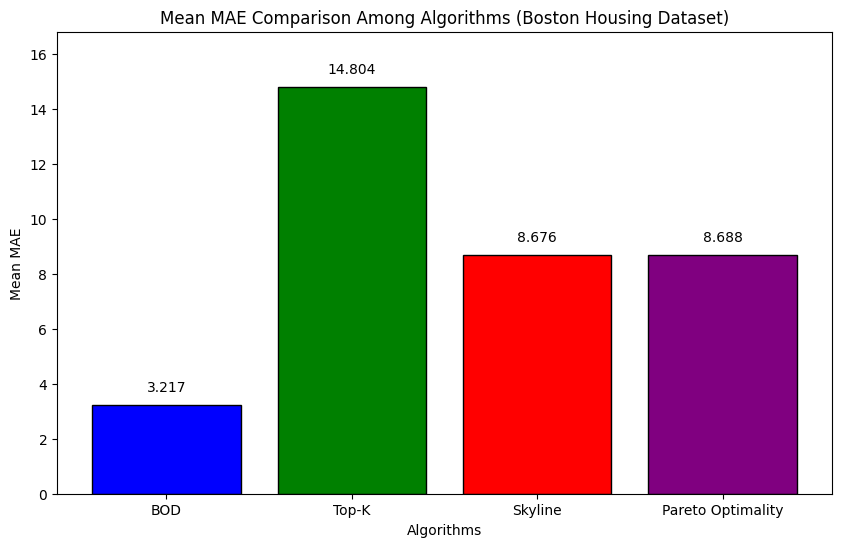

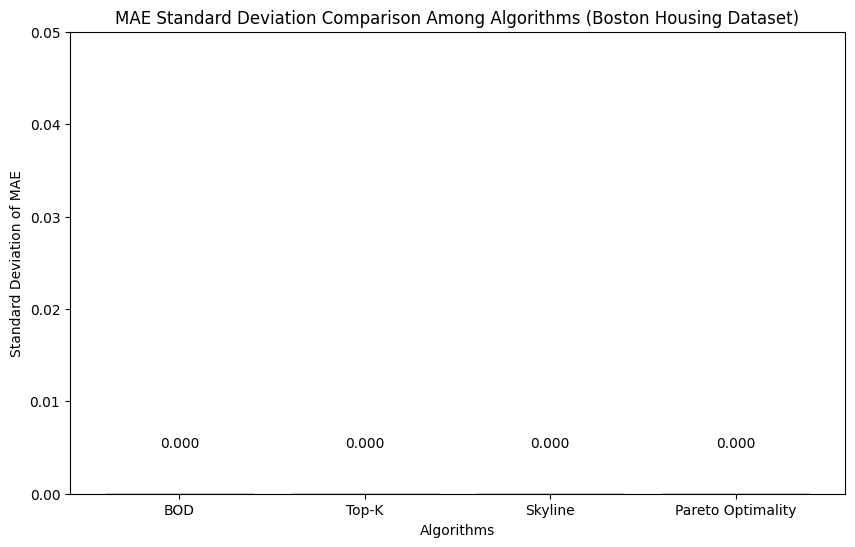

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Step 1: Load, Clean, and Normalize the Dataset
file_path = "HousingData_Boston.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Handle missing values by filling with the column mean
df.fillna(df.mean(), inplace=True)

# Normalize the data to be within the range [0, 1]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Step 2: Generate Housing Prices Based on the New Utility Function
housing_prices = (
    1.0 * df_scaled['CRIM'] +
    2/3 * df_scaled['INDUS'] +
    1/3 * df_scaled['CHAS'] +
    1.0 * df_scaled['RM'] +
    2/3 * df_scaled['AGE'] +
    1/3 * df_scaled['DIS'] +
    1.0 * df_scaled['TAX'] +
    1/3 * df_scaled['PTRATIO'] +
    2/3 * df_scaled['LSTAT'] +
    np.random.normal(scale=0.2, size=len(df_scaled))  # Adding some random noise
)

# Number of iterations for stability test
num_iterations = 10

# Initialize a dictionary to store MAE scores for stability analysis
mae_stability = {
    "BOD": [],
    "Top-K": [],
    "Skyline": [],
    "Pareto Optimality": []
}

def run_single_experiment(data, housing_prices):
    ################################### BOD Implementation ###################################
    def bod_algorithm(data):
        selected_columns_1 = data[['CRIM', 'RM', 'TAX']]
        y_min_1 = selected_columns_1.sum(axis=1).quantile(0.75)
        y_max_1 = selected_columns_1.sum(axis=1).max()

        filter_1st_dataframe = data[(y_min_1 <= data.sum(axis=1)) & (data.sum(axis=1) <= y_max_1)]
        if filter_1st_dataframe.empty:
            return data  # Return the previous selection if the filter results in an empty dataframe

        selected_columns_2 = filter_1st_dataframe[['CRIM', 'RM', 'TAX', 'AGE', 'INDUS', 'LSTAT']]
        y_min_2 = selected_columns_2.sum(axis=1).quantile(0.75)
        y_max_2 = selected_columns_2.sum(axis=1).max()

        filter_2nd_theFinal_dataframe = filter_1st_dataframe[
            (y_min_2 <= filter_1st_dataframe.sum(axis=1)) &
            (filter_1st_dataframe.sum(axis=1) <= y_max_2)
        ]
        if filter_2nd_theFinal_dataframe.empty:
            return filter_1st_dataframe

        selected_columns_3 = filter_2nd_theFinal_dataframe
        y_min_3 = selected_columns_3.sum(axis=1).quantile(0.75)
        y_max_3 = selected_columns_3.sum(axis=1).max()

        filter_3rd_dataframe = filter_2nd_theFinal_dataframe[
            (y_min_3 <= filter_2nd_theFinal_dataframe.sum(axis=1)) &
            (filter_2nd_theFinal_dataframe.sum(axis=1) <= y_max_3)
        ]
        if filter_3rd_dataframe.empty:
            return filter_2nd_theFinal_dataframe

        return filter_3rd_dataframe

    ################################### Unsupervised Top-k Algorithm ###################################
    def unsupervised_top_k_algorithm(data, k=10):
        data['score'] = data.sum(axis=1)
        top_k_selection = data.nlargest(k, 'score')
        return top_k_selection

    ################################### Alternative Skyline Algorithm ###################################
    def alternative_skyline_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        skyline_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            dominated = False
            for j in range(len(skyline_set)):
                if dominates(skyline_set[j], row):
                    dominated = True
                    break
                if dominates(row, skyline_set[j]):
                    skyline_set[j] = row
                    dominated = True
                    break
            if not dominated:
                skyline_set.append(row)

        skyline_df = pd.DataFrame(skyline_set)
        return skyline_df

    ################################### Pareto Optimality Algorithm ###################################
    def pareto_optimal_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        pareto_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            if not any(dominates(other_row, row) for other_row in data.values):
                pareto_set.append(row)

        pareto_df = pd.DataFrame(pareto_set)
        return pareto_df

    ################################### MAE Comparison ###################################
    # BOD MAE
    bod_selection = bod_algorithm(data)
    if not bod_selection.empty:
        bod_mae = mean_absolute_error(housing_prices[:len(bod_selection)], bod_selection.sum(axis=1))
    else:
        bod_mae = np.nan

    # Unsupervised Top-k MAE
    top_k_selection = unsupervised_top_k_algorithm(data, k=10)
    top_k_mae = mean_absolute_error(housing_prices[:len(top_k_selection)], top_k_selection.sum(axis=1))

    # Alternative Skyline MAE
    skyline_selection = alternative_skyline_algorithm(data)
    skyline_mae = mean_absolute_error(housing_prices[:len(skyline_selection)], skyline_selection.sum(axis=1))

    # Pareto Optimality MAE
    pareto_selection = pareto_optimal_algorithm(data)
    pareto_mae = mean_absolute_error(housing_prices[:len(pareto_selection)], pareto_selection.sum(axis=1))

    return {
        "BOD": bod_mae,
        "Top-K": top_k_mae,
        "Skyline": skyline_mae,
        "Pareto Optimality": pareto_mae
    }

# Run the experiments for stability
stability_results = Parallel(n_jobs=-1)(delayed(run_single_experiment)(df_scaled, housing_prices) for _ in range(num_iterations))

# Aggregate results to calculate mean and standard deviation
for algorithm in mae_stability.keys():
    maes = [result[algorithm] for result in stability_results if not np.isnan(result[algorithm])]
    mae_stability[algorithm] = {
        "mean": np.mean(maes),
        "std_dev": np.std(maes)
    }

# Print the stability results
for algorithm, stats in mae_stability.items():
    print(f"{algorithm}: Mean MAE = {stats['mean']:.3f}, Standard Deviation = {stats['std_dev']:.3f}")

# Plotting the results

# Extract data for plotting
algorithms = list(mae_stability.keys())
mean_maes = [mae_stability[alg]["mean"] for alg in algorithms]
std_devs = [mae_stability[alg]["std_dev"] for alg in algorithms]

# Create a bar chart for Mean MAE
plt.figure(figsize=(10, 6))
plt.bar(algorithms, mean_maes, color=['blue', 'green', 'red', 'purple', 'orange'], edgecolor='black')
plt.title('Mean MAE Comparison Among Algorithms (Boston Housing Dataset)')
plt.xlabel('Algorithms')
plt.ylabel('Mean MAE')
plt.ylim(0, max(mean_maes) + 2)

# Add MAE values on top of the bars
for i, v in enumerate(mean_maes):
    plt.text(i, v + 0.5, f"{v:.3f}", ha='center')

plt.show()

# Create a bar chart for Standard Deviation of MAE
plt.figure(figsize=(10, 6))
plt.bar(algorithms, std_devs, color=['blue', 'green', 'red', 'purple', 'orange'], edgecolor='black')
plt.title('MAE Standard Deviation Comparison Among Algorithms (Boston Housing Dataset)')
plt.xlabel('Algorithms')
plt.ylabel('Standard Deviation of MAE')
plt.ylim(0, max(std_devs) + 0.05)

# Add standard deviation values on top of the bars
for i, v in enumerate(std_devs):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center')

plt.show()


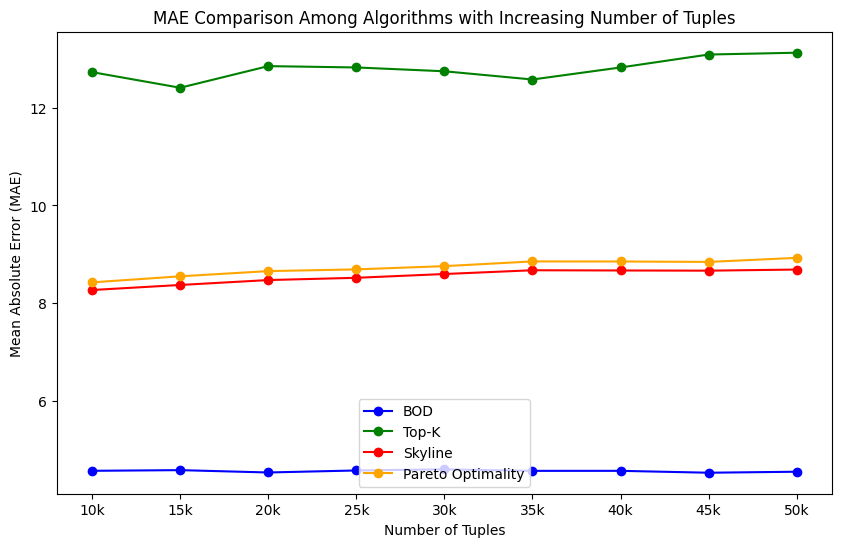

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Number of iterations
num_iterations = 1

# List of row sizes to test
row_sizes = range(10000, 50001, 5000)

# Initialize a dictionary to store average MAE for different row sizes
mae_results = {
    "BOD": [],
    "Top-K": [],
    "Skyline": [],
    "Pareto Optimality": []
}

def run_experiment(row):
    # Generate random data for location, house, and policy features
    combined_data = np.random.rand(row, 9)
    columns = ['near_urban', 'crime_free', 'view', 'size', 'age', 'style', 'policy', 'tax', 'growth']
    combined_data = pd.DataFrame(combined_data, columns=columns)

    # Normalize the data
    scaler = MinMaxScaler()
    combined_data_normalized = pd.DataFrame(scaler.fit_transform(combined_data), columns=columns)

    # Calculate the housing price based on the new criteria (this serves as our target variable)
    housing_prices = (
        1/3 * combined_data_normalized['near_urban'] +
        1.0 * combined_data_normalized['crime_free'] +
        2/3 * combined_data_normalized['view'] +
        1/3 * combined_data_normalized['size'] -
        2/3 * combined_data_normalized['age'] +
        1.0 * combined_data_normalized['style'] +
        1.0 * combined_data_normalized['policy'] -
        1/3 * combined_data_normalized['tax'] +
        2/3 * combined_data_normalized['growth'] +
        np.random.normal(scale=0.1, size=row)  # Adding some random noise
    )

    ################################### BOD Implementation ###################################
    def bod_algorithm(data):
        selected_columns_1 = data[['crime_free', 'style', 'policy']].sum(axis=1)
        y_min_1 = selected_columns_1.quantile(0.75)
        y_max_1 = selected_columns_1.max()

        filter_1st = data[(y_min_1 <= selected_columns_1) & (selected_columns_1 <= y_max_1)]
        if filter_1st.empty:
            return filter_1st

        selected_columns_2 = filter_1st[['crime_free', 'style', 'policy', 'view', 'age', 'growth']].sum(axis=1)
        y_min_2 = selected_columns_2.quantile(0.75)
        y_max_2 = selected_columns_2.max()

        filter_2nd = filter_1st[(y_min_2 <= selected_columns_2) & (selected_columns_2 <= y_max_2)]
        if filter_2nd.empty:
            return filter_1st

        selected_columns_3 = filter_2nd.sum(axis=1)
        y_min_3 = selected_columns_3.quantile(0.75)
        y_max_3 = selected_columns_3.max()

        filter_3rd = filter_2nd[(y_min_3 <= selected_columns_3) & (selected_columns_3 <= y_max_3)]
        return filter_3rd if not filter_3rd.empty else filter_2nd

    ################################### Unsupervised Top-k Algorithm ###################################
    def unsupervised_top_k_algorithm(data, k=10):
        data['score'] = data.sum(axis=1)
        return data.nlargest(k, 'score')

    ################################### Alternative Skyline Algorithm ###################################
    def alternative_skyline_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        skyline_set = []
        data_array = data.values  # Convert to numpy for faster row-wise operations
        for i in range(len(data_array)):
            row = data_array[i]
            dominated = False
            for j in range(len(skyline_set)):
                if dominates(skyline_set[j], row):
                    dominated = True
                    break
                if dominates(row, skyline_set[j]):
                    skyline_set[j] = row
                    dominated = True
                    break
            if not dominated:
                skyline_set.append(row)

        return pd.DataFrame(skyline_set, columns=data.columns)

    ################################### Pareto Optimality Algorithm ###################################
    def pareto_optimal_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        pareto_set = []
        data_array = data.values
        for i in range(len(data_array)):
            row = data_array[i]
            if not any(dominates(other_row, row) for other_row in data_array):
                pareto_set.append(row)

        return pd.DataFrame(pareto_set, columns=data.columns)

    ################################### MAE Comparison ###################################
    # BOD MAE
    bod_selection = bod_algorithm(combined_data_normalized)
    if bod_selection.empty:
        bod_mae = np.nan
    else:
        bod_mae = mean_absolute_error(housing_prices[:len(bod_selection)], bod_selection.sum(axis=1))

    # Unsupervised Top-k MAE
    top_k_selection = unsupervised_top_k_algorithm(combined_data_normalized, k=10)
    top_k_mae = mean_absolute_error(housing_prices[:len(top_k_selection)], top_k_selection.sum(axis=1))

    # Alternative Skyline MAE
    skyline_selection = alternative_skyline_algorithm(combined_data_normalized)
    skyline_mae = mean_absolute_error(housing_prices[:len(skyline_selection)], skyline_selection.sum(axis=1))

    # Pareto Optimality MAE
    pareto_selection = pareto_optimal_algorithm(combined_data_normalized)
    pareto_mae = mean_absolute_error(housing_prices[:len(pareto_selection)], pareto_selection.sum(axis=1))

    return {
        "BOD": bod_mae,
        "Top-K": top_k_mae,
        "Skyline": skyline_mae,
        "Pareto Optimality": pareto_mae
    }

# Run the experiments in parallel for different row sizes
for row in row_sizes:
    row_results = Parallel(n_jobs=-1)(delayed(run_experiment)(row) for _ in range(num_iterations))

    # Compute the mean MAE for each algorithm
    mean_bod = np.nanmean([result["BOD"] for result in row_results])
    mean_top_k = np.nanmean([result["Top-K"] for result in row_results])
    mean_skyline = np.nanmean([result["Skyline"] for result in row_results])
    mean_pareto = np.nanmean([result["Pareto Optimality"] for result in row_results])

    # Store the results
    mae_results["BOD"].append(mean_bod)
    mae_results["Top-K"].append(mean_top_k)
    mae_results["Skyline"].append(mean_skyline)
    mae_results["Pareto Optimality"].append(mean_pareto)

# Format the row sizes for better readability (e.g., 1000 -> 1k, 10000 -> 10k)
formatted_row_sizes = [f'{int(row/1000)}k' for row in row_sizes]

# Plot the results for each row size as a line chart
plt.figure(figsize=(10, 6))
plt.plot(formatted_row_sizes, mae_results["BOD"], marker='o', label='BOD', color='blue')
plt.plot(formatted_row_sizes, mae_results["Top-K"], marker='o', label='Top-K', color='green')
plt.plot(formatted_row_sizes, mae_results["Skyline"], marker='o', label='Skyline', color='red')
plt.plot(formatted_row_sizes, mae_results["Pareto Optimality"], marker='o', label='Pareto Optimality', color='orange')

# Add title and labels
plt.title('MAE Comparison Among Algorithms with Increasing Number of Tuples')
plt.xlabel('Number of Tuples')
plt.ylabel('Mean Absolute Error (MAE)')

# Add a legend
plt.legend()

# Display the chart
plt.show()
